In [ ]:
!pip install pytorch-tabnet

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn import neighbors
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## no warning print

import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [ ]:
train = pd.read_csv('/content/train.csv')
check0 = pd.read_csv('/content/check0.csv')
check1 = pd.read_csv('/content/check1.csv')
submit = pd.read_csv('/content/submit.csv')

In [ ]:
def xy_split(df):
  y = df[['유입량']].astype(float)
  X = df.drop(['date', '홍수사상번호', '유입량', '연', '월', '일', '시간'], axis=1).astype(float)

  y = y.reset_index(drop=True)
  X = X.reset_index(drop=True)

  return y, X

y_train, X_train = xy_split(train)  #1 ~ 23번 홍수사상
y_val, X_val = xy_split(check0)   #24번 홍수사상
y_test, X_test = xy_split(check1) #25번 홍수사상
_, X_submit = xy_split(submit)

In [ ]:
X_train_all = X_train.copy()
X_val_all = X_val.copy()
X_test_all = X_test.copy()
X_submit_all = X_submit.copy()

In [ ]:
#LASSO 피처셀렉션 결과 사용

X_train = X_train[['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean', 'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max', 'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max']]

X_val = X_val[['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean', 'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max', 'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max']]

X_test = X_test[['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean', 'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max', 'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max']]

X_submit = X_submit[['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean', 'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max', 'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max']]

# 1. Ridge

In [ ]:
ridge_reg = Ridge(alpha = 1.0, normalize = True, random_state = 1).fit(X_train, y_train)

In [ ]:
#randomsearch를 활용한 parameter 튜닝
Parameters={'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]}
 
Random_Search = RandomizedSearchCV(ridge_reg, Parameters, n_iter=5, cv=5, n_jobs=1, verbose=5, random_state=10)
RandomSearchResults=Random_Search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.848, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.775, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.778, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.843, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.851, total=   0.0s
[CV] alpha=0.32 ......................................................
[CV] .......................... alpha=0.32, score=0.887, total=   0.0s
[CV] alpha=0.32 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=0.16, score=0.885, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.758, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.776, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.820, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.843, total=   0.0s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


In [ ]:
best_params = RandomSearchResults.best_params_

ridge_reg.set_params(**best_params).fit(X_train, y_train)

Ridge(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=1, solver='auto', tol=0.001)

In [ ]:
#독립변수들을 활용하여 fitting value 추출
pred_train_ridge = ridge_reg.predict(X_train)
pred_val_ridge = ridge_reg.predict(X_val)
pred_test_ridge = ridge_reg.predict(X_test)
pred_submit_ridge = ridge_reg.predict(X_submit)

In [ ]:
#train, validation, test RMSE
print('train_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_train_ridge) - np.expm1(y_train)) ** 2).mean()) ** 0.5))
print('val_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_val_ridge) - np.expm1(y_val)) ** 2).mean()) ** 0.5))
print('test_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_test_ridge) - np.expm1(y_test)) ** 2).mean()) ** 0.5) )

train_RMSE: 유입량    1172.461891
dtype: float64
val_RMSE: 유입량    380.514358
dtype: float64
test_RMSE: 유입량    281.010274
dtype: float64


# 2. KNN

In [ ]:
KNN_reg = neighbors.KNeighborsRegressor(n_neighbors = 10).fit(X_train, y_train)

In [ ]:
#randomsearch를 활용한 parameter 튜닝
Parameters={'n_neighbors': [1, 2, 4, 8, 16],
            'weights': ['uniform', 'distance']}
 
Random_Search = RandomizedSearchCV(KNN_reg, Parameters, n_iter=5, cv=5, n_jobs=1, verbose=5, random_state=10)
RandomSearchResults=Random_Search.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] weights=uniform, n_neighbors=16 .................................
[CV] ..... weights=uniform, n_neighbors=16, score=0.132, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] ..... weights=uniform, n_neighbors=16, score=0.316, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-1.542, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-0.287, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-0.903, total=   0.0s
[CV] weights=uniform, n_neighbors=2 ..................................
[CV] ...... weights=uniform, n_neighbors=2, score=0.017, total=   0.0s
[CV] weights=uniform, n_neighbors=2 ..................................
[CV] ...... weigh

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] .... weights=distance, n_neighbors=4, score=-0.339, total=   0.0s
[CV] weights=distance, n_neighbors=4 .................................
[CV] .... weights=distance, n_neighbors=4, score=-0.992, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ...... weights=uniform, n_neighbors=8, score=0.082, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ...... weights=uniform, n_neighbors=8, score=0.226, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-1.795, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-0.289, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-0.995, total=   0.0s
[CV] weights=distance, n_neighbors=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


In [ ]:
best_params = RandomSearchResults.best_params_

KNN_reg.set_params(**best_params).fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                    weights='uniform')

In [ ]:
#독립변수들을 활용하여 fitting value 추출
pred_train_KNN = KNN_reg.predict(X_train)
pred_val_KNN = KNN_reg.predict(X_val)
pred_test_KNN = KNN_reg.predict(X_test)
pred_submit_KNN = KNN_reg.predict(X_submit)

In [ ]:
#train, validation, test RMSE
print('train_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_train_KNN) - np.expm1(y_train)) ** 2).mean()) ** 0.5) )
print('val_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_val_KNN) - np.expm1(y_val)) ** 2).mean()) ** 0.5))
print('test_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_test_KNN) - np.expm1(y_test)) ** 2).mean()) ** 0.5))

train_RMSE: 유입량    944.809909
dtype: float64
val_RMSE: 유입량    1069.643953
dtype: float64
test_RMSE: 유입량    714.143845
dtype: float64


# 3. Polynomial

In [ ]:
#단일 변수의 2차식을 독립변수로 하여 종속변수와 회귀모형 적합
tmp1 = pd.concat([y_train, X_train], axis = 1)
indeps = X_train.columns
pvalue_lst = []
resid_lst = []

for i in range(len(indeps)) :
  tmp = tmp1.copy()
  tmp[indeps[i]] = tmp[indeps[i]]**2
  fit = ols('유입량~'+indeps[i], data=tmp).fit()
  pvalue = fit.pvalues[1]
  pvalue_lst.append(pvalue)
  rmse = np.sqrt(np.mean(fit.resid**2))
  resid_lst.append(rmse)

In [ ]:
compare = pd.DataFrame({'name' : list(indeps),
                        'residual' : resid_lst,
                        'pvalue' : pvalue_lst})

In [ ]:
#통계적으로 유의하며, 적절한 RMSE를 가진 변수들만 추출
sig_vars = list(compare.loc[(compare.residual<=0.75)&(compare.pvalue<0.05),'name'])

#해당 변수들만을 활용하여 회귀 모형 적합
tmp = train.copy()
tmp[sig_vars] = tmp[sig_vars]**2

ols_fit = ols('유입량~'+'+'.join(sig_vars), data=tmp).fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    유입량   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     4804.
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        03:55:53   Log-Likelihood:                -2262.8
No. Observations:                2694   AIC:                             4532.
Df Residuals:                    2691   BIC:                             4549.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.4187      0.020    274.738      0.000       5.380       5.457
수위E_max           0.0592      0.002     38.358      0.000       0.056       0.062
lag_1_강우D_max     0.0647      0.002     36.931      0.000       0.061       0.068
==============================================================================
Omnibus:                      519.048   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2026.202
Skew:                          -0.903   Prob(JB):                         0.00
Kurtosis:                       6.845   Cond. No.                         37.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#독립변수들을 활용하여 fitting value 추출
pred_train_poly = ols_fit.predict(X_train**2)
pred_val_poly = ols_fit.predict(X_val**2)
pred_test_poly = ols_fit.predict(X_test**2)
pred_submit_poly = ols_fit.predict(X_submit**2)

In [ ]:
pred_train_poly = np.array(pred_train_poly).reshape(-1,1)
pred_val_poly = np.array(pred_val_poly).reshape(-1,1)
pred_test_poly = np.array(pred_test_poly).reshape(-1,1)
pred_submit_poly = np.array(pred_submit_poly).reshape(-1,1)

In [ ]:
#train, validation, test RMSE
print('train_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_train_poly) - np.expm1(y_train)) ** 2).mean()) ** 0.5) )
print('val_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_val_poly) - np.expm1(y_val)) ** 2).mean()) ** 0.5))
print('test_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_test_poly) - np.expm1(y_test)) ** 2).mean()) ** 0.5))

train_RMSE: 유입량    4386.096636
dtype: float64
val_RMSE: 유입량    367.253803
dtype: float64
test_RMSE: 유입량    273.208561
dtype: float64


# 4. PCA

In [ ]:
#독립변수 스케일링
scaler = StandardScaler()

column_names = X_train_all.columns
X_train_all = scaler.fit_transform(X_train_all)
X_train_all = pd.DataFrame(X_train_all)
X_train_all.columns = column_names

def scaling(df) :
  df_scaled = scaler.transform(df)
  df_scaled = pd.DataFrame(df_scaled)
  df_scaled.columns = column_names
  return df_scaled

X_val_all = scaling(X_val_all)
X_test_all = scaling(X_test_all)
X_submit_all = scaling(X_submit_all)

In [ ]:
#2개의 Principal Component 구성
pca = PCA(n_components=3)
pca.fit(X_train_all)
pca_X_train = pca.fit_transform(X_train_all)

pca_X_val = pca.transform(X_val_all)
pca_X_test = pca.transform(X_test_all)
pca_X_submit = pca.transform(X_submit_all)

In [ ]:
pca.explained_variance_ratio_

array([0.53487749, 0.17276497, 0.06344607])

In [ ]:
def concat_pca(x, y=None) :
  x = pd.DataFrame(x)
  x.columns = ['x1', 'x2', 'x3']
  x['x1'] = x['x1']**2
  x['x2'] = x['x2']**2
  x['x3'] = x['x3']**2
  if y is None :
    return x
  else :
    y = y.reset_index(drop=True)
    df = pd.concat([y, x], axis=1)
    return df

train_pca = concat_pca(pca_X_train, y_train)
val_pca = concat_pca(pca_X_val, y_val)
test_pca = concat_pca(pca_X_test, y_test)
submit_pca = concat_pca(x=pca_X_submit)

In [ ]:
#Principal Component를 활용한 회귀모형 적합 및 fitting value 추출
pca_ols_fit = ols('유입량 ~ x1 + x2 + x3', data = train_pca).fit()

pred_train_pca = pca_ols_fit.predict(train_pca)
pred_val_pca = pca_ols_fit.predict(val_pca)
pred_test_pca = pca_ols_fit.predict(test_pca)
pred_submit_pca = pca_ols_fit.predict(submit_pca)

In [ ]:
pred_train_pca = np.array(pred_train_pca).reshape(-1,1)
pred_val_pca = np.array(pred_val_pca).reshape(-1,1)
pred_test_pca = np.array(pred_test_pca).reshape(-1,1)
pred_submit_pca = np.array(pred_submit_pca).reshape(-1,1)

In [ ]:
#train, validation, test RMSE
print('train_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_train_pca) - np.expm1(y_train)) ** 2).mean()) ** 0.5) )
print('val_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_val_pca) - np.expm1(y_val)) ** 2).mean()) ** 0.5))
print('test_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_test_pca) - np.expm1(y_test)) ** 2).mean()) ** 0.5))

train_RMSE: 유입량    2397.260435
dtype: float64
val_RMSE: 유입량    1167.024166
dtype: float64
test_RMSE: 유입량    352.90119
dtype: float64


# 5. TabNet

In [ ]:
#array 형식으로 변환
X_train_DL=X_train.values
y_train_DL=y_train.values

X_val_DL=X_val.values
y_val_DL=y_val.values

X_test_DL=X_test.values
y_test_DL=y_test.values

X_submit_DL=X_submit.values

## parameters

In [ ]:
## Parameters for Tabnet model 
##parameter
MAX_EPOCH =1000 #apply early stopping
BATCH_SIZE = 100
Random_seed=42
N_FOLD=5

## hyperparameter 
N_D = 9 #Width of the decision prediction layer
N_A = 9 #Width of the attention embedding for each mask

#default
N_STEPS = 2 
GAMMA = 1.1
LAMBDA_SPARSE = 0
OPT_LR = 1e-3
OPT_WEIGHT_DECAY = 1e-5
OPT_MOMENTUM = 0.9
MASK_TYPE = "sparsemax"
SCHEDULER_MIN_LR = 1e-6
SCHEDULER_FACTOR = 0.9
DEVICE_NAME = "cuda"

In [ ]:
tabnet_params = dict(n_d=N_D, n_a=N_A, n_steps=N_STEPS, gamma=GAMMA,
                     lambda_sparse=LAMBDA_SPARSE, optimizer_fn=torch.optim.SGD,
                     optimizer_params=dict(lr=OPT_LR, weight_decay=OPT_WEIGHT_DECAY, momentum=OPT_MOMENTUM),
                     mask_type=MASK_TYPE,
                     scheduler_params=dict(mode="min",
                                           patience=20,
                                           min_lr=SCHEDULER_MIN_LR,
                                           factor=SCHEDULER_FACTOR,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10,
                     device_name=DEVICE_NAME,
                     seed=Random_seed
                     )

In [ ]:
#random seed
import random
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(Random_seed)

## fit the model

In [ ]:
CV_score_array=[]
mse_fold=[]

##random K-fold CV
kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=Random_seed)

for f, (train_index, test_index) in enumerate(kf.split(X_train_DL)): 
      print(f'Fold {f}')
      
      ## for CV, redefine datastet

      train_X, valid_X = X_train_DL[train_index], X_train_DL[test_index]
      train_y, valid_y = y_train_DL[train_index], y_train_DL[test_index]

      ## define model 
      model = TabNetRegressor(**tabnet_params)

      # fit the model
      model_fitting=model.fit(X_train=train_X,
                              y_train=train_y,
                              eval_set=[(valid_X, valid_y)],
                              eval_name = ["val"],
                              eval_metric = ['rmse'],
                              max_epochs=MAX_EPOCH,
                              patience=20, batch_size=BATCH_SIZE,
                              num_workers=1, drop_last=False)
      temp_oof = model.predict(valid_X) #pred of val.
      CV_score_array.append(model.best_cost)

#model evaluation metric
cv_score=np.expm1(np.mean(CV_score_array,axis=0))

Fold 0
Device used : cuda
epoch 0  | loss: 36.25804| val_rmse: 8.73817 |  0:00:01s
epoch 10 | loss: 21.04046| val_rmse: 4.52272 |  0:00:08s
epoch 20 | loss: 6.98043 | val_rmse: 2.5844  |  0:00:15s
epoch 30 | loss: 1.9278  | val_rmse: 1.23955 |  0:00:22s
epoch 40 | loss: 1.0177  | val_rmse: 0.9     |  0:00:29s
epoch 50 | loss: 0.78916 | val_rmse: 0.73682 |  0:00:36s
epoch 60 | loss: 0.72779 | val_rmse: 0.65623 |  0:00:43s
epoch 70 | loss: 0.45864 | val_rmse: 0.55441 |  0:00:50s
epoch 80 | loss: 0.40096 | val_rmse: 0.53605 |  0:00:58s
epoch 90 | loss: 0.39663 | val_rmse: 0.47632 |  0:01:04s
epoch 100| loss: 0.30612 | val_rmse: 0.4568  |  0:01:11s
epoch 110| loss: 0.27863 | val_rmse: 0.44325 |  0:01:18s
epoch 120| loss: 0.25773 | val_rmse: 0.42125 |  0:01:26s
epoch 130| loss: 0.22456 | val_rmse: 0.41102 |  0:01:33s
epoch 140| loss: 0.20231 | val_rmse: 0.38958 |  0:01:40s
epoch 150| loss: 0.26037 | val_rmse: 0.38608 |  0:01:48s
epoch 160| loss: 0.22937 | val_rmse: 0.38775 |  0:01:55s
epoch

In [ ]:
pred_train_DL = model.predict(X_train_DL)
pred_val_DL = model.predict(X_val_DL)
pred_test_DL = model.predict(X_test_DL)
pred_submit_DL = model.predict(X_submit_DL)

In [ ]:
#train, validation, test RMSE
print('train_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_train_DL) - np.expm1(y_train)) ** 2).mean()) ** 0.5) )
print('val_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_val_DL) - np.expm1(y_val)) ** 2).mean()) ** 0.5))
print('test_RMSE: {RMSE}'.format(RMSE = (((np.expm1(pred_test_DL) - np.expm1(y_test)) ** 2).mean()) ** 0.5))

train_RMSE: 유입량    808.674608
dtype: float64
val_RMSE: 유입량    440.976749
dtype: float64
test_RMSE: 유입량    271.433201
dtype: float64


# 결과 추출

In [ ]:
result_train = pd.DataFrame()

result_train['pred_train_ridge'] = pred_train_ridge.reshape(-1)
result_train['pred_train_KNN'] = pred_train_KNN.reshape(-1)
result_train['pred_train_poly'] = pred_train_poly.reshape(-1)
result_train['pred_train_pca'] = pred_train_pca.reshape(-1)
result_train['pred_train_DL'] = pred_train_DL.reshape(-1)


result_val = pd.DataFrame()

result_val['pred_val_ridge'] = pred_val_ridge.reshape(-1)
result_val['pred_val_KNN'] = pred_val_KNN.reshape(-1)
result_val['pred_val_poly'] = pred_val_poly.reshape(-1)
result_val['pred_val_pca'] = pred_val_pca.reshape(-1)
result_val['pred_val_DL'] = pred_val_DL.reshape(-1)


result_test = pd.DataFrame()

result_test['pred_test_ridge'] = pred_test_ridge.reshape(-1)
result_test['pred_test_KNN'] = pred_test_KNN.reshape(-1)
result_test['pred_test_poly'] = pred_test_poly.reshape(-1)
result_test['pred_test_pca'] = pred_test_pca.reshape(-1)
result_test['pred_test_DL'] = pred_test_DL.reshape(-1)


result_submit = pd.DataFrame()

result_submit['pred_submit_ridge'] = pred_submit_ridge.reshape(-1)
result_submit['pred_submit_KNN'] = pred_submit_KNN.reshape(-1)
result_submit['pred_submit_poly'] = pred_submit_poly.reshape(-1)
result_submit['pred_submit_pca'] = pred_submit_pca.reshape(-1)
result_submit['pred_submit_DL'] = pred_submit_DL.reshape(-1)

In [ ]:
result_train.to_csv('result_train.csv', index = False)
result_val.to_csv('result_val.csv', index = False)
result_test.to_csv('result_test.csv', index = False)
result_submit.to_csv('result_submit.csv', index = False)

# 25번까지 학습시켜서 최종 예측값 추출

## Ridge

In [ ]:
new_X_train = pd.concat([X_train, X_val, X_test], axis = 0).reset_index(drop=True)
new_y_train = pd.concat([y_train, y_val, y_test], axis = 0).reset_index(drop=True)

In [ ]:
new_ridge_reg = Ridge(alpha = 1.0, normalize = True, random_state = 1).fit(new_X_train, new_y_train)

In [ ]:
#randomsearch를 활용한 parameter 튜닝
Parameters={'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]}
 
Random_Search = RandomizedSearchCV(new_ridge_reg, Parameters, n_iter=5, cv=5, n_jobs=1, verbose=5, random_state=10)
RandomSearchResults=Random_Search.fit(new_X_train, new_y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.848, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.744, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.853, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.822, total=   0.0s
[CV] alpha=0.04 ......................................................
[CV] .......................... alpha=0.04, score=0.824, total=   0.0s
[CV] alpha=0.32 ......................................................
[CV] .......................... alpha=0.32, score=0.891, total=   0.0s
[CV] alpha=0.32 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s



[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.886, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.725, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.844, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.800, total=   0.0s
[CV] alpha=0.16 ......................................................
[CV] .......................... alpha=0.16, score=0.806, total=   0.0s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


In [ ]:
best_params = RandomSearchResults.best_params_

new_ridge_reg.set_params(**best_params).fit(new_X_train, new_y_train)

Ridge(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=1, solver='auto', tol=0.001)

In [ ]:
new_pred_submit_ridge = new_ridge_reg.predict(X_submit)

## KNN

In [ ]:
new_KNN_reg = neighbors.KNeighborsRegressor(n_neighbors = 10).fit(new_X_train, new_y_train)

In [ ]:
#randomsearch를 활용한 parameter 튜닝
Parameters={'n_neighbors': [1, 2, 4, 8, 16],
            'weights': ['uniform', 'distance']}
 
Random_Search = RandomizedSearchCV(new_KNN_reg, Parameters, n_iter=5, cv=5, n_jobs=1, verbose=5, random_state=10)
RandomSearchResults=Random_Search.fit(new_X_train, new_y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] weights=uniform, n_neighbors=16 .................................
[CV] ..... weights=uniform, n_neighbors=16, score=0.187, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] ..... weights=uniform, n_neighbors=16, score=0.348, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-1.432, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-0.237, total=   0.0s
[CV] weights=uniform, n_neighbors=16 .................................
[CV] .... weights=uniform, n_neighbors=16, score=-0.571, total=   0.0s
[CV] weights=uniform, n_neighbors=2 ..................................
[CV] ...... weights=uniform, n_neighbors=2, score=0.033, total=   0.0s
[CV] weights=uniform, n_neighbors=2 ..................................
[CV] ...... weigh

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] .... weights=distance, n_neighbors=4, score=-0.402, total=   0.0s
[CV] weights=distance, n_neighbors=4 .................................
[CV] .... weights=distance, n_neighbors=4, score=-0.729, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ...... weights=uniform, n_neighbors=8, score=0.126, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ...... weights=uniform, n_neighbors=8, score=0.290, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-1.744, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-0.265, total=   0.0s
[CV] weights=uniform, n_neighbors=8 ..................................
[CV] ..... weights=uniform, n_neighbors=8, score=-0.677, total=   0.0s
[CV] weights=distance, n_neighbors=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


In [ ]:
best_params = RandomSearchResults.best_params_

new_KNN_reg.set_params(**best_params).fit(new_X_train, new_y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                    weights='uniform')

In [ ]:
new_pred_submit_KNN = new_KNN_reg.predict(X_submit)

## poly

In [ ]:
#단일 변수의 2차식을 독립변수로 하여 종속변수와 회귀모형 적합
tmp1 = pd.concat([new_y_train, new_X_train], axis = 1)
indeps = new_X_train.columns
pvalue_lst = []
resid_lst = []

for i in range(len(indeps)) :
  tmp = tmp1.copy()
  tmp[indeps[i]] = tmp[indeps[i]]**2
  fit = ols('유입량~'+indeps[i], data=tmp).fit()
  pvalue = fit.pvalues[1]
  pvalue_lst.append(pvalue)
  rmse = np.sqrt(np.mean(fit.resid**2))
  resid_lst.append(rmse)

In [ ]:
compare = pd.DataFrame({'name' : list(indeps),
                        'residual' : resid_lst,
                        'pvalue' : pvalue_lst})

In [ ]:
#통계적으로 유의하며, 적절한 RMSE를 가진 변수들만 추출
sig_vars = list(compare.loc[(compare.residual<=0.75)&(compare.pvalue<0.05),'name'])

#해당 변수들만을 활용하여 회귀 모형 적합
tmp = train.copy()
tmp[sig_vars] = tmp[sig_vars]**2

ols_fit = ols('유입량~'+'+'.join(sig_vars), data=tmp).fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    유입량   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     4804.
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        05:01:16   Log-Likelihood:                -2262.8
No. Observations:                2694   AIC:                             4532.
Df Residuals:                    2691   BIC:                             4549.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.4187      0.020    274.738      0.000       5.380       5.457
수위E_max           0.0592      0.002     38.358      0.000       0.056       0.062
lag_1_강우D_max     0.0647      0.002     36.931      0.000       0.061       0.068
==============================================================================
Omnibus:                      519.048   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2026.202
Skew:                          -0.903   Prob(JB):                         0.00
Kurtosis:                       6.845   Cond. No.                         37.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
new_pred_submit_poly = ols_fit.predict(X_submit**2)
new_pred_submit_poly = np.array(new_pred_submit_poly).reshape(-1,1)

## PCA

In [ ]:
new_X_train_all = pd.concat([X_train_all, X_val_all, X_test_all], axis = 0).reset_index(drop=True)

In [ ]:
#독립변수 스케일링
scaler = StandardScaler()

column_names = new_X_train_all.columns
new_X_train_all = scaler.fit_transform(new_X_train_all)
new_X_train_all = pd.DataFrame(new_X_train_all)
new_X_train_all.columns = column_names

def scaling(df) :
  df_scaled = scaler.transform(df)
  df_scaled = pd.DataFrame(df_scaled)
  df_scaled.columns = column_names
  return df_scaled

X_submit_all = scaling(X_submit_all)

In [ ]:
#2개의 Principal Component 구성
pca = PCA(n_components=3)
pca.fit(new_X_train_all)
new_pca_X_train = pca.fit_transform(new_X_train_all)


new_pca_X_submit = pca.transform(X_submit_all)

In [ ]:
pca.explained_variance_ratio_

array([0.53540854, 0.17001565, 0.06304673])

In [ ]:
def concat_pca(x, y=None) :
  x = pd.DataFrame(x)
  x.columns = ['x1', 'x2', 'x3']
  x['x1'] = x['x1']**2
  x['x2'] = x['x2']**2
  x['x3'] = x['x3']**2
  if y is None :
    return x
  else :
    y = y.reset_index(drop=True)
    df = pd.concat([y, x], axis=1)
    return df

new_train_pca = concat_pca(new_pca_X_train, y_train)

new_submit_pca = concat_pca(x=new_pca_X_submit)

In [ ]:
#Principal Component를 활용한 회귀모형 적합 및 fitting value 추출
pca_ols_fit = ols('유입량 ~ x1 + x2 + x3', data = new_train_pca).fit()

new_pred_submit_pca = pca_ols_fit.predict(new_submit_pca)
new_pred_submit_pca = np.array(new_pred_submit_pca).reshape(-1,1)

## DL

In [ ]:
new_X_train_DL = new_X_train.values
new_y_train_DL = new_y_train.values

### parameters

In [ ]:
## Parameters for Tabnet model 
##parameter
MAX_EPOCH =1000 #apply early stopping
BATCH_SIZE = 100
Random_seed=42
N_FOLD=5

## hyperparameter 
N_D = 9 #Width of the decision prediction layer
N_A = 9 #Width of the attention embedding for each mask

#default
N_STEPS = 2 
GAMMA = 1.1
LAMBDA_SPARSE = 0
OPT_LR = 1e-3
OPT_WEIGHT_DECAY = 1e-5
OPT_MOMENTUM = 0.9
MASK_TYPE = "sparsemax"
SCHEDULER_MIN_LR = 1e-6
SCHEDULER_FACTOR = 0.9
DEVICE_NAME = "cuda"

In [ ]:
tabnet_params = dict(n_d=N_D, n_a=N_A, n_steps=N_STEPS, gamma=GAMMA,
                     lambda_sparse=LAMBDA_SPARSE, optimizer_fn=torch.optim.SGD,
                     optimizer_params=dict(lr=OPT_LR, weight_decay=OPT_WEIGHT_DECAY, momentum=OPT_MOMENTUM),
                     mask_type=MASK_TYPE,
                     scheduler_params=dict(mode="min",
                                           patience=20,
                                           min_lr=SCHEDULER_MIN_LR,
                                           factor=SCHEDULER_FACTOR,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10,
                     device_name=DEVICE_NAME,
                     seed=Random_seed
                     )

In [ ]:
#random seed
import random
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(Random_seed)

### fit the model

In [ ]:
CV_score_array=[]
mse_fold=[]

##random K-fold CV
kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=Random_seed)

for f, (train_index, test_index) in enumerate(kf.split(new_X_train_DL)): 
      print(f'Fold {f}')
      
      ## for CV, redefine datastet

      train_X, valid_X = new_X_train_DL[train_index], new_X_train_DL[test_index]
      train_y, valid_y = new_y_train_DL[train_index], new_y_train_DL[test_index]

      ## define model 
      model = TabNetRegressor(**tabnet_params)

      # fit the model
      model_fitting=model.fit(X_train=train_X,
                              y_train=train_y,
                              eval_set=[(valid_X, valid_y)],
                              eval_name = ["val"],
                              eval_metric = ['rmse'],
                              max_epochs=MAX_EPOCH,
                              patience=20, batch_size=BATCH_SIZE,
                              num_workers=1, drop_last=False)
      temp_oof = model.predict(valid_X) #pred of val.
      CV_score_array.append(model.best_cost)

#model evaluation metric
cv_score=np.expm1(np.mean(CV_score_array,axis=0))

Fold 0
Device used : cuda
epoch 0  | loss: 35.5911 | val_rmse: 8.01996 |  0:00:00s
epoch 10 | loss: 21.93437| val_rmse: 4.63182 |  0:00:09s
epoch 20 | loss: 8.81    | val_rmse: 2.95601 |  0:00:18s
epoch 30 | loss: 2.42941 | val_rmse: 1.43612 |  0:00:27s
epoch 40 | loss: 1.14138 | val_rmse: 0.9214  |  0:00:35s
epoch 50 | loss: 0.7985  | val_rmse: 0.74896 |  0:00:44s
epoch 60 | loss: 0.63459 | val_rmse: 0.65409 |  0:00:52s
epoch 70 | loss: 0.51945 | val_rmse: 0.61641 |  0:01:01s
epoch 80 | loss: 0.42431 | val_rmse: 0.56171 |  0:01:09s
epoch 90 | loss: 0.37201 | val_rmse: 0.46897 |  0:01:18s
epoch 100| loss: 0.3766  | val_rmse: 0.48568 |  0:01:27s
epoch 110| loss: 0.32652 | val_rmse: 0.42517 |  0:01:36s
epoch 120| loss: 0.31244 | val_rmse: 0.40541 |  0:01:44s
epoch 130| loss: 0.26401 | val_rmse: 0.41865 |  0:01:53s
epoch 140| loss: 0.26948 | val_rmse: 0.41523 |  0:02:02s
epoch 150| loss: 0.23932 | val_rmse: 0.38755 |  0:02:10s
epoch 160| loss: 0.24424 | val_rmse: 0.3961  |  0:02:19s
epoch

In [ ]:
new_pred_submit_DL = model.predict(X_submit_DL)

## 결과 추출

In [ ]:
final_result_submit = pd.DataFrame()

final_result_submit['new_pred_submit_ridge'] = new_pred_submit_ridge.reshape(-1)
final_result_submit['new_pred_submit_KNN'] = new_pred_submit_KNN.reshape(-1)
final_result_submit['new_pred_submit_poly'] = new_pred_submit_poly.reshape(-1)
final_result_submit['new_pred_submit_pca'] = new_pred_submit_pca.reshape(-1)
final_result_submit['new_pred_submit_DL'] = new_pred_submit_DL.reshape(-1)

In [ ]:
final_result_submit.to_csv('final_result_submit.csv', index = False)

# DL 해석

In [ ]:
explain_matrix, masks = model.explain(X_test_DL)

In [ ]:
import random
rnd = random.sample(range(1, 103), 30)
rnd = sorted(rnd)

In [ ]:
X_train.columns

Index(['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean',
       'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max',
       'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max'],
      dtype='object')

In [ ]:
cumsum_강우A_mean, cumsum_강우A_max, cumsum_수위E_max

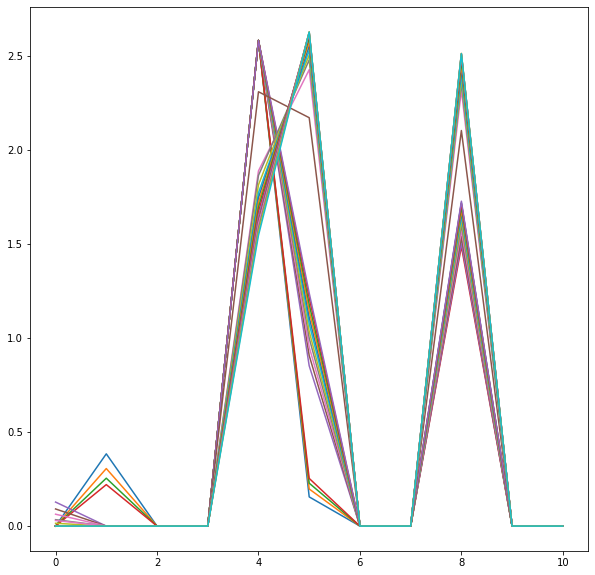

In [ ]:
plt.figure(figsize = (10,10))
for i in range(len(rnd)):
  plt.plot(explain_matrix[i])